# Upper Animas PEST Pilot Point Setup

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import flopy as flopy
import pyemu
import shapefile #the pyshp module
from pyemu.pst.pst_utils import SFMT,IFMT,FFMT,pst_config
import matplotlib.pyplot as plt


In [2]:
# from apexmf import apexmf_pst_utils

In [5]:

sys.path.insert(1, 'd:/spark-brc_gits/apexmf_git/')
from apexmf import apexmf_pst_par, apexmf_utils
from apexmf import apexmf_pst_utils

In [6]:
wd = "d:/Projects/Watersheds/Gunnison/Analysis/AMRSs/Gunnison_APEX-MODFLOW-Salt/APEX-MODFLOW-Salt/"
# pstfile = "gns_pest_r.pst"
os.chdir(wd)

# MODFLOW parameters with Pilot Points

In [5]:
# m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=wd,load_only=[]) #<-- load only prevents reading ibound
mname = 'mf_1000.nam'
m = flopy.modflow.Modflow.load(mname,
            model_ws=os.path.join(wd)
            )
m.check()

Errors and/or Warnings encountered.
Errors and/or Warnings encountered.

mf_1000 MODEL DATA VALIDATION SUMMARY:
  8794 Warnings:
    OC package: action(s) defined in OC stress_period_data ignored as they are not part the stress periods defined by DIS
    RCH package: Mean R/T ratio < checker warning threshold of 2e-08 for 1 stress periods
    RCH package: Variable NRCHOP set to value other than 3
    RIV package: BC in inactive cell
    UPW package: specific yield values above checker threshold of 0.5
    UPW package: specific yield values below checker threshold of 0.01

  Checks that passed:
    Unit number conflicts
    Compatible solver package
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    UPW package: zero or negative horizontal hydraulic conductivity v

In [9]:
sr = pyemu.helpers.SpatialReference.from_namfile(
        os.path.join(wd, "mf_1000.nam"),
        delr=m.dis.delr.array, delc=m.dis.delc.array)

   could not remove start_datetime


In [ ]:
# Create pilot points as a shapefile
# we want hk pilot points in the top layer...
prefix_dict = {0:["sy0"]}
df_pp_hk = pyemu.pp_utils.setup_pilotpoints_grid(ml=m,
                                              prefix_dict=prefix_dict,
                                              pp_dir=wd,
                                              tpl_dir=wd,
                                              every_n_cell=10,
                                              shapename='pp_sy.shp')

In [15]:
# change shapefile and file name
shpwd = wd
shp = 'pp_sy.shp'
shp_changed = 'sy0pp.shp'
ppf = shp_changed[:-3] + 'dat'
ppf

'sy0pp.dat'

In [16]:
shpwd = os.path.join(wd, "MODFLOW")

In [17]:
#read file, parse out the records and shapes
shapefile_path = os.path.join(shpwd, shp)
sf = shapefile.Reader(shapefile_path)

#grab the shapefile's field names (omit the first psuedo field)
fields = [x[0] for x in sf.fields][1:]
records = sf.records()
shps = [s.points for s in sf.shapes()]

#write the records into a dataframe
shapefile_dataframe = pd.DataFrame(columns=fields, data=records)

#add the coordinate data to a column called "coords"
shapefile_dataframe = shapefile_dataframe.assign(coords=shps)

pp_df = shapefile_dataframe.sort_values(by=['name'])
print(pp_df)

        name        x         y  zone  parval1  k    i   j               tpl   
0    pp_0000  65500.0  151500.0   1.0      1.0  0    5  65  ~    sy0000    ~  \
1    pp_0001  45500.0  141500.0   1.0      1.0  0   15  45  ~    sy0001    ~   
2    pp_0002  55500.0  141500.0   1.0      1.0  0   15  55  ~    sy0002    ~   
3    pp_0003  65500.0  141500.0   1.0      1.0  0   15  65  ~    sy0003    ~   
4    pp_0004  75500.0  141500.0   1.0      1.0  0   15  75  ~    sy0004    ~   
..       ...      ...       ...   ...      ... ..  ...  ..               ...   
142  pp_0142  55500.0   11500.0   1.0      1.0  0  145  55  ~    sy0142    ~   
143  pp_0143  65500.0   11500.0   1.0      1.0  0  145  65  ~    sy0143    ~   
144  pp_0144  75500.0   11500.0   1.0      1.0  0  145  75  ~    sy0144    ~   
145  pp_0145  85500.0   11500.0   1.0      1.0  0  145  85  ~    sy0145    ~   
146  pp_0146  95500.0   11500.0   1.0      1.0  0  145  95  ~    sy0146    ~   

     parnme  ...                       

- get list of salt ion
- change tpl name for new par name
- write dataframe to pp.dat file
- write tpl file for pp.dat file


# you got to make co3 and hco3 too although you don't have

In [48]:
sions_ = ["SO4", "Ca", "Mg", "Na", "K", "Cl", "CO3", "HCO3"]
sions = [i.lower() for i in sions_] 
sions

['so4', 'ca', 'mg', 'na', 'k', 'cl', 'co3', 'hco3']

In [49]:
sionsf = [f"salt_{i.lower()}0pp.dat.ref" for i in sions_] 

In [50]:
sionsf

['salt_so40pp.dat.ref',
 'salt_ca0pp.dat.ref',
 'salt_mg0pp.dat.ref',
 'salt_na0pp.dat.ref',
 'salt_k0pp.dat.ref',
 'salt_cl0pp.dat.ref',
 'salt_co30pp.dat.ref',
 'salt_hco30pp.dat.ref']

In [56]:
conts = [1.8e+006, 50000, 20000, 1.8e+007, 30000, 5e+007, 5e+007, 5e+007]
rgs = [45900, 20700, 35100, 35100, 27000, 28800, 28800, 28800]


In [57]:
def change_tpl_name(tpl_df, newnam, oldnam='sy'):
    tpl_df['tpl'] = tpl_df['tpl'].str.replace(oldnam, newnam)
    tpl_df['pargp'] = tpl_df['pargp'].str.replace(oldnam, newnam)
    tpl_df['parnme'] = tpl_df['parnme'].str.replace(oldnam, newnam)
    return tpl_df

In [58]:
PP_FMT = {"name": SFMT, "x": FFMT, "y": FFMT, "zone": IFMT, "tpl": SFMT,
          "parval1": FFMT}
def pp_to_tpl(new_df, pp_file, tpl_file=None):
    names = new_df['parnme'].tolist() # for hk
    # names = new_df['sypar'].tolist() # for sy  
#     names = new_df['parnme'].tolist() # for river conductance      
    if tpl_file is None:
        tpl_file = pp_file + ".tpl"    
    tpl_entries = ["~    {0}    ~".format(name) for name in names]
    new_df.loc[:,"tpl"] = tpl_entries
    new_df.loc[:,"parnme"] = names


    f_tpl = open(tpl_file,'w')
    f_tpl.write("ptf ~\n")
    f_tpl.write(new_df.to_string(col_space=0,
                              columns=["name","x","y","zone","tpl"],
                              formatters=PP_FMT,
                              justify="left",
                              header=False,
                              index=False) + '\n')    


In [59]:
def intp_krigging(cont, a, new_df, ionnam):
    v = pyemu.geostats.ExpVario(contribution=cont,a=a, bearing=0)
    gs = pyemu.geostats.GeoStruct(variograms=v,nugget=0)
    ok = pyemu.geostats.OrdinaryKrige(gs,new_df)
    df = ok.calc_factors_grid(sr,
    #                           var_filename=pst_name.replace(".pst",".var.ref"),
                              var_filename= f"salt_{ionnam}0pp." + "var.ref",                          
                              minpts_interp=1,maxpts_interp=50,
                              search_radius=5000000000000.0)
    ok.to_grid_factors_file(f"salt_{ionnam}0pp.dat"+".fac")

In [60]:
for ionnam, cont, rg in zip(sions, conts, rgs):
    df = pp_df.copy()
    # write dataframe to pp.dat file
    new_df = change_tpl_name(df, f"salt_{ionnam}", oldnam='sy')
    pyemu.utils.pp_utils.write_pp_file(f"salt_{ionnam}0pp.dat", new_df) # create dat
    pp_to_tpl(new_df, f"salt_{ionnam}0pp.dat") # create tpl
    intp_krigging(cont, rg, new_df, ionnam)

starting interp point loop for 24649 points
took 92.468587 seconds
starting interp point loop for 24649 points
took 94.999418 seconds
starting interp point loop for 24649 points
took 94.118843 seconds
starting interp point loop for 24649 points
took 94.121582 seconds
starting interp point loop for 24649 points
took 90.725636 seconds
starting interp point loop for 24649 points
took 90.913603 seconds
starting interp point loop for 24649 points
took 91.760943 seconds
starting interp point loop for 24649 points
took 91.937067 seconds


In [25]:
ionnam = "so4"

In [26]:
df = pp_df.copy()
# write dataframe to pp.dat file
new_df = change_tpl_name(df, f"salt_{ionnam}", oldnam='sy')

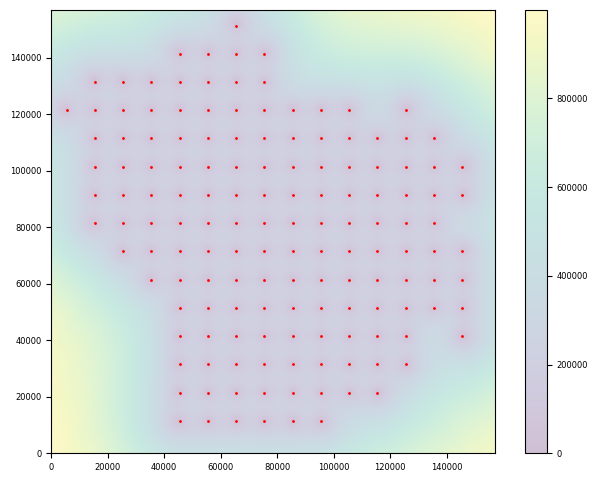

In [27]:
# arr_var = np.loadtxt(pst_name.replace(".pst",".var.ref"))
arr_var = np.loadtxt(f"salt_{ionnam}0pp." + "var.ref")
ax = plt.subplot(111,aspect="equal")
p = ax.imshow(arr_var,extent=sr.get_extent(),alpha=0.25)
plt.colorbar(p)
plt.tight_layout()
ax.scatter(pp_df.x,pp_df.y,marker='.',s=4,color='r')

In [28]:
# generate random values
new_df.loc[:,"parval1"] = np.random.random(new_df.shape[0])
# save a pilot points file
pyemu.pp_utils.write_pp_file(f"salt_{ionnam}0pp.dat",new_df)

In [29]:
# interpolate the pilot point values to the grid
hk_arr = pyemu.utils.geostats.fac2real(f"salt_{ionnam}0pp.dat",factors_file=f"salt_{ionnam}0pp.dat"+".fac",out_file=None)

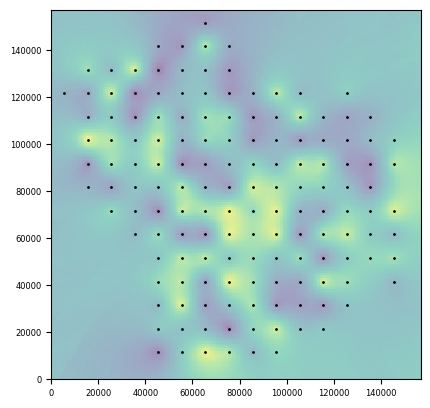

In [30]:
# plot
ax = plt.subplot(111,aspect='equal')
ax.imshow(hk_arr,interpolation="nearest",extent=sr.get_extent(),alpha=0.5)
ax.scatter(new_df.x,new_df.y,marker='.',s=4,color='k')

# create ins file for salt ... done

In [18]:
os.chdir(wd)

In [19]:
io_files = pyemu.helpers.parse_dir_for_io_files('.')
pst = pyemu.Pst.from_io_files(*io_files)


In [20]:
par = pst.parameter_data
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
salt_ca0000,salt_ca0000,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
salt_ca0001,salt_ca0001,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
salt_ca0002,salt_ca0002,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
salt_ca0003,salt_ca0003,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
salt_ca0004,salt_ca0004,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
salt_so40142,salt_so40142,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
salt_so40143,salt_so40143,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
salt_so40144,salt_so40144,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1
salt_so40145,salt_so40145,log,factor,1.0,1.100000e-10,1.100000e+10,pargp,1.0,0.0,1


# set par gp

In [21]:
for i in range(len(par)):
    par.iloc[i, 6] = par.iloc[i, 0][:-3]
    

In [22]:
par

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom
salt_ca0000,salt_ca0000,log,factor,1.0,1.100000e-10,1.100000e+10,salt_ca0,1.0,0.0,1
salt_ca0001,salt_ca0001,log,factor,1.0,1.100000e-10,1.100000e+10,salt_ca0,1.0,0.0,1
salt_ca0002,salt_ca0002,log,factor,1.0,1.100000e-10,1.100000e+10,salt_ca0,1.0,0.0,1
salt_ca0003,salt_ca0003,log,factor,1.0,1.100000e-10,1.100000e+10,salt_ca0,1.0,0.0,1
salt_ca0004,salt_ca0004,log,factor,1.0,1.100000e-10,1.100000e+10,salt_ca0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...
salt_so40142,salt_so40142,log,factor,1.0,1.100000e-10,1.100000e+10,salt_so40,1.0,0.0,1
salt_so40143,salt_so40143,log,factor,1.0,1.100000e-10,1.100000e+10,salt_so40,1.0,0.0,1
salt_so40144,salt_so40144,log,factor,1.0,1.100000e-10,1.100000e+10,salt_so40,1.0,0.0,1
salt_so40145,salt_so40145,log,factor,1.0,1.100000e-10,1.100000e+10,salt_so40,1.0,0.0,1


In [23]:
obd = pst.observation_data
obd

,obsnme,obsval,weight,obgnme
d064_cca_20090721,d064_cca_20090721,17.007259,1.0,obgnme
d064_cca_20090806,d064_cca_20090806,33.347103,1.0,obgnme
d064_cca_20091103,d064_cca_20091103,41.293358,1.0,obgnme
d064_cca_20100126,d064_cca_20100126,82.068596,1.0,obgnme
d064_cca_20100409,d064_cca_20100409,81.557762,1.0,obgnme
...,...,...,...,...
m064_lso4_201508,m064_lso4_201508,212484.370000,1.0,obgnme
m064_lso4_201509,m064_lso4_201509,211230.790000,1.0,obgnme
m064_lso4_201510,m064_lso4_201510,211156.230000,1.0,obgnme
m064_lso4_201511,m064_lso4_201511,209991.250000,1.0,obgnme


In [24]:
for i in range(len(obd)):
    if (obd.iloc[i, 0][5:9]) == 'lso4' or (obd.iloc[i, 0][5:9]) == 'cso4':
        obd.iloc[i, 3] = obd.iloc[i, 0][:9]
    elif (obd.iloc[i, 0][5:10]) == 'lhco3' or (obd.iloc[i, 0][5:10]) == 'chco3':
        obd.iloc[i, 3] = obd.iloc[i, 0][:10]
    elif (obd.iloc[i, 0][5:7]) == 'lk' or (obd.iloc[i, 0][5:7]) == 'ck':
        obd.iloc[i, 3] = obd.iloc[i, 0][:7]
    else:
        obd.iloc[i, 3] = obd.iloc[i, 0][:8]


In [25]:
obd

,obsnme,obsval,weight,obgnme
d064_cca_20090721,d064_cca_20090721,17.007259,1.0,d064_cca
d064_cca_20090806,d064_cca_20090806,33.347103,1.0,d064_cca
d064_cca_20091103,d064_cca_20091103,41.293358,1.0,d064_cca
d064_cca_20100126,d064_cca_20100126,82.068596,1.0,d064_cca
d064_cca_20100409,d064_cca_20100409,81.557762,1.0,d064_cca
...,...,...,...,...
m064_lso4_201508,m064_lso4_201508,212484.370000,1.0,m064_lso4
m064_lso4_201509,m064_lso4_201509,211230.790000,1.0,m064_lso4
m064_lso4_201510,m064_lso4_201510,211156.230000,1.0,m064_lso4
m064_lso4_201511,m064_lso4_201511,209991.250000,1.0,m064_lso4


## 2.3. Import measured data

In [29]:
# calibration period
sim_start_day = '1/1/2007'
cali_start_day = '7/1/2009'
cali_end_day = '12/31/2015'

In [26]:
# set variables
salt_subs = [64]
time_steps = ['day', 'mon']
obd_files = []
for i in salt_subs:
    for k in time_steps:
        obd_files.append("salt_{:03d}_{}.obd".format(i, k))
obd_files

['salt_064_day.obd', 'salt_064_mon.obd']

In [37]:
salt_df = pd.read_csv(
                    "SALINITY/salt.output.channels",
                    delim_whitespace=True,
                    skiprows=4,
                    header=0,
                    index_col=0,
                    )
salt_df = salt_df.iloc[:, 5:] # only cols we need
colnams = salt_df.columns.tolist()
colnam_sort = colnams

In [38]:
colnam_sort.sort()

In [39]:
tot_obd = []
for obdf in obd_files:
    salt_obd = pd.read_csv(
                        obdf,
                        sep='\t',
#                         usecols=['date', col_name],
                        index_col=0,
                        parse_dates=True,
                        na_values=[-999, '']
                        )
    salt_obd = salt_obd[cali_start_day:cali_end_day]
    salt_obd = salt_obd[~salt_obd.index.duplicated(keep='first')]
    for caln in colnam_sort:
        if caln in salt_obd.columns:
            tot_obd += salt_obd.loc[:, caln].dropna().tolist()  

In [42]:
obd.loc[:, 'obsval'] = tot_obd

# 4. Export control file

In [44]:
# set test run and command
pst.control_data.noptmax=0
pst.model_command = 'python salt_forward_run.py'
pst.model_input_data = apexmf_pst_utils.modify_mf_tpl_path(pst.model_input_data)
pst.write(os.path.join(wd, 'gns_amrs_pp.pst'), version=2)

noptmax:0, npar_adj:1176, nnz_obs:960


In [44]:
t_d = os.path.join(wd, "ies_template_pp")

In [68]:
os.chdir(wd)

In [69]:
# test run
pyemu.os_utils.run("pestpp-ies gns_amrs_pp.pst")

Exception: run() returned non-zero: -1073740791